In [1]:
from mdagent import MDAgent
import os 
import mdtraj as md

In [2]:
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
from robustness_prompts import get_prompt

prompt_8_descriptive = get_prompt("descriptive", 8)
prompt_8_natural = get_prompt("natural", 8)

prompt_8_descriptive, prompt_8_natural

('Complete all of the following tasks: 1. Download the PDB file 1LYZ. 2. Report the secondary structure assignments of the downloaded PDB structure. 3. Find any known binding or active sites. 4. Simulate for 1ps at 300 K. 5. Compute the RMSD. 6. Compute the radius of gyration over time. 7. Compute the SASA (solvent accessible surface area). 8. Simulate for 1ps at 400K. You do not need to do any analysis of the 400K simulation.',
 'Simulate 1LYZ for 1ps at 300 K and for 1ps at 400K. Report the secondary structure assignments of the downloaded PDB structure and any known binding or active sites. Compute the RMSD, SASA, and radius of gyration of the 300K simulation.')

In [3]:
llm_model = "claude-3-opus-20240229"
tools = "all"

In [4]:
agent_1 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_1.run(prompt_8_descriptive)

Thought: To complete the tasks, I will need to download the PDB file for 1LYZ, analyze its structure, find binding/active sites, run simulations at different temperatures, and compute various structural properties. I will start by downloading the PDB file.

Action:
```
{
  "action": "PDBFileDownloader",
  "action_input": "1LYZ"
}
```

PDB file found with this ID: 1LYZ
Thought: Now that I have the PDB file downloaded, I can analyze the secondary structure using the ComputeDSSP tool.

Action:
```
{
  "action": "ComputeDSSP",
  "action_input": {
    "traj_file": null,
    "top_file": "1LYZ_010256",
    "target_frames": "first"
  }
}
```

/Users/samanthacox/Desktop/md-agent/mdagent/utils/data_handling.py:49: UserWarning: Trajectory File ID is not provided but is not required; loading MDTrajectory from topology 1LYZ_010256 only.
  warnings.warn(


Thought: Now that I have the secondary structure information, I will look for any known binding or active sites for this protein using the GetAllKnownSites tool.

Action:
```
{
  "action": "GetAllKnownSites",
  "action_input": {
    "query": "1LYZ",
    "primary_accession": "P00698"
  }
}
```

Thought: Now that I have the PDB file, secondary structure, and binding/active site information, I can proceed with setting up and running a short 1ps simulation at 300K using the SetUpandRunFunction tool. I will use the AMBER14SB forcefield.

Action:
```
{
  "action": "SetUpandRunFunction",
  "action_input": {
    "pdb_id": "1LYZ_010256",
    "forcefield_files": ["amber14-all.xml", "amber14/tip3pfb.xml"],
    "save": true,
    "system_params": {
      "nonbondedMethod": "PME",
      "nonbondedCutoff": "1.0 * nanometers",
      "ewaldErrorTolerance": 0.0005,
      "constraints": "HBonds",
      "rigidWater": true,
      "constraintTolerance": 0.00001,
      "solvate": true
    },
    "integrator_

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

<Figure size 640x480 with 0 Axes>

In [10]:
registry_1 = agent_1.path_registry
print(registry_1.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_010256: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_010256
 rec0_010306: dssp values for trajectory with id: None
 1LYZ_010342: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_010358: Initial positions for simulation sim0_010358
 sim0_010358: Basic Simulation of Protein 1LYZ_010342
 rec0_010402: Simulation trajectory for protein 1LYZ_010342 and simulation sim0_010358
 rec1_010402: Simulation state log for protein 1LYZ_010342 and simulation sim0_010358
 rec2_010402: Simulation pdb frames for protein 1LYZ_010342 and simulation sim0_010358
 rmsd_1LYZ: RMSD for 1LYZ
 fig0_010820: RMSD plot for 1LYZ
 rgy_rec0_010402: Radii of gyration per frame for rec0_010402
 fig0_010835: Plot of radii of gyration over time for rec0_010402
 sasa_1LYZ: Total SASA values for 1LYZ
 fig0_011815: Plot of SASA over time for 1LYZ
 top_sim0_011830: In

In [11]:
# make sure pdb was downloaded
assert os.path.exists(registry_1.get_mapped_path("1LYZ_010256"))

In [12]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_1)
dssp._run(traj_file= "1LYZ_010256", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [13]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P00698")

"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}, {'start': 70, 'start_modifier': 'EXACT', 'end': 70, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nBinding Sites: [{'start': 119, 'start_modifier': 'EXACT', 'end': 119, 'end_modifier': 'EXACT', 'description': '', 'evidences': []}]\nNo other relevant sites."

In [15]:
# make sure trajectory and topology exist (sim1)
traj_path_1_1 = registry_1.get_mapped_path("rec0_010402")
top_path_1_1 = registry_1.get_mapped_path("top_sim0_010358")

assert os.path.exists(traj_path_1_1)
assert os.path.exists(top_path_1_1)

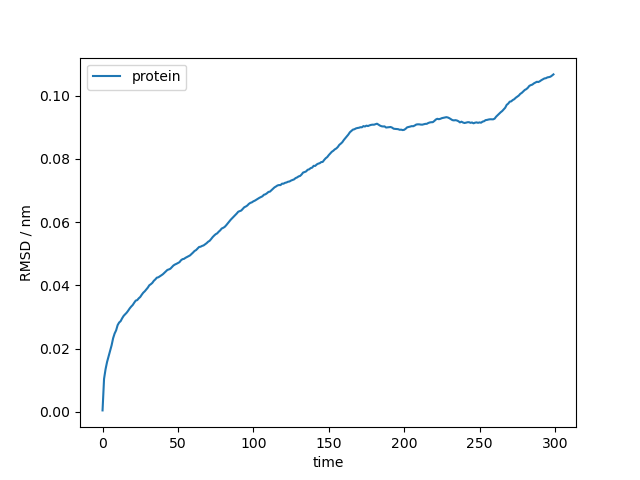

In [16]:
# make sure rmsd plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_010820'))

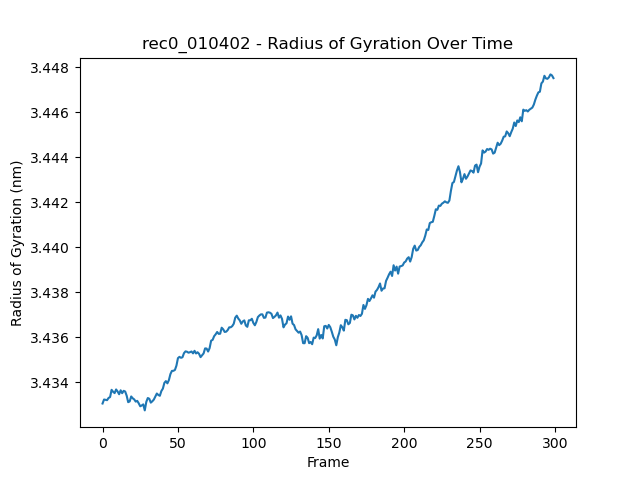

In [17]:
# make sure rgy plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_010835'))

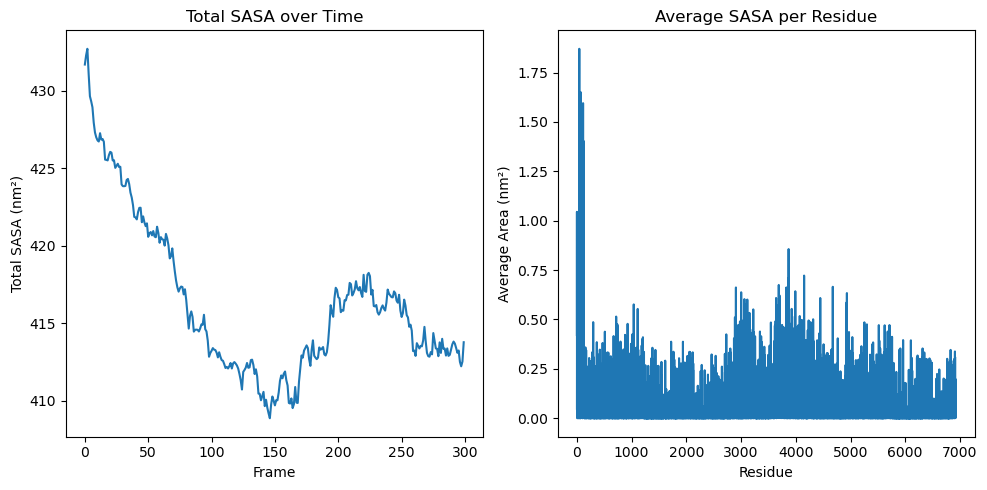

In [18]:
# make sure sasa plot was generated (sim1)
from IPython.display import Image
Image(filename=registry_1.get_mapped_path('fig0_011815'))

In [19]:
# make sure trajectory and topology exist (sim2)
traj_path_1_2 = registry_1.get_mapped_path("top_sim0_011830")
top_path_1_2 = registry_1.get_mapped_path("rec0_011834")

assert os.path.exists(traj_path_1_2)
assert os.path.exists(top_path_1_2)

In [21]:
agent_2 = MDAgent(agent_type="Structured", model=llm_model, top_k_tools=tools, use_memory=False)
agent_2.run(prompt_8_natural)

Thought: To simulate 1LYZ at different temperatures and analyze the results, I will need to:
1. Download the PDB file for 1LYZ
2. Set up and run simulations at 300K and 400K 
3. Compute secondary structure of the PDB file
4. Look up any known binding or active sites
5. Compute RMSD, SASA, and radius of gyration for the 300K simulation

I will start by downloading the PDB file.

Action:
```
{
  "action": "PDBFileDownloader",
  "action_input": "1LYZ"
}
```

PDB file found with this ID: 1LYZ
Thought: Now that I have the PDB file for 1LYZ, I will set up and run a short 1ps simulation at 300K and 400K using the SetUpandRunFunction tool. This will generate a script that can be used to reproduce the simulations.

Action:
```
{
  "action": "SetUpandRunFunction",
  "action_input": {
    "pdb_id": "1LYZ_031354",
    "forcefield_files": ["amber14/protein.ff14SB.xml", "amber14/tip3p.xml"],
    "save": true,
    "system_params": {
      "nonbondedMethod": "PME", 
      "nonbondedCutoff": "1.0 * nan

({'input': '\n    You are an expert molecular dynamics scientist, and\n    your task is to respond to the question or\n    solve the problem to the best of your ability using\n    the provided tools.\n\n    You can only respond with a single complete\n    \'Thought, Action, Action Input\' format\n    OR a single \'Final Answer\' format.\n\n    Complete format:\n    Thought: (reflect on your progress and decide what to do next)\n    Action:\n    ```\n    {\n        "action": (the action name, it should be the name of a tool),\n        "action_input": (the input string for the action)\n    }\n    \'\'\'\n\n    OR\n\n    Final Answer: (the final response to the original input\n    question, once all steps are complete)\n\n    You are required to use the tools provided,\n    using the most specific tool\n    available for each action.\n    Your final answer should contain all information\n    necessary to answer the question and its subquestions.\n    Before you finish, reflect on your pro

In [29]:
registry_2 = agent_2.path_registry
print(registry_2.list_path_names_and_descriptions().replace(",", "\n"))

Files found in registry: 1LYZ_031354: PDB file downloaded from RSCB
 PDBFile ID: 1LYZ_031354
 1LYZ_031417: Cleaned File:  Removed Heterogens
 and Water Removed.  Replaced Nonstandard Residues. Added Hydrogens at pH 7.0. Missing Atoms Added and replaces nonstandard residues. 
 top_sim0_031431: Initial positions for simulation sim0_031431
 sim0_031431: Basic Simulation of Protein 1LYZ_031417
 rec0_031438: Simulation trajectory for protein 1LYZ_031417 and simulation sim0_031431
 rec1_031438: Simulation state log for protein 1LYZ_031417 and simulation sim0_031431
 rec2_031438: Simulation pdb frames for protein 1LYZ_031417 and simulation sim0_031431
 top_sim0_031814: Initial positions for simulation sim0_031814
 sim0_031814: Basic Simulation of Protein 1LYZ_031417
 rec0_031820: Simulation trajectory for protein 1LYZ_031417 and simulation sim0_031814
 rec1_031820: Simulation state log for protein 1LYZ_031417 and simulation sim0_031814
 rec2_031820: Simulation pdb frames for protein 1LYZ_0314

In [25]:
# make sure pdb was downloaded
assert os.path.exists(registry_2.get_mapped_path("1LYZ_031354"))

In [26]:
# make sure dssp was computed correctly
from mdagent.tools.base_tools import ComputeDSSP

dssp = ComputeDSSP(registry_2)
dssp._run(traj_file= "1LYZ_031354", target_frames="first")

"{'residues in helix': 50, 'residues in strand': 14, 'residues in coil': 65, 'residues not assigned, not a protein residue': 101}"

In [27]:
# make sure the sites were found
from mdagent.tools.base_tools import GetAllKnownSites

get_all_known_sites = GetAllKnownSites()
get_all_known_sites._run(query="1LYZ", primary_accession="P61626")

The primary accession number provided does not match any entry in the data, using the first entry instead.
The primary accession number provided does not match any entry in the data, using the first entry instead.
The primary accession number provided does not match any entry in the data, using the first entry instead.


"Active Sites: [{'start': 53, 'start_modifier': 'EXACT', 'end': 53, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}, {'start': 71, 'start_modifier': 'EXACT', 'end': 71, 'end_modifier': 'EXACT', 'description': '', 'evidences': [{'evidenceCode': 'ECO:0000255', 'source': 'PROSITE-ProRule', 'id': 'PRU00680'}]}]\nNo known binding sites.\nNo other relevant sites."

In [31]:
# make sure trajectory and topology exist (sim1)
traj_path_2_1 = registry_2.get_mapped_path("sim0_031431")
top_path_2_1 = registry_2.get_mapped_path("top_sim0_031431")

assert os.path.exists(traj_path_2_1)
assert os.path.exists(top_path_2_1)

In [30]:
# make sure trajectory and topology exist (sim1)
traj_path_2_2 = registry_2.get_mapped_path("rec0_031820")
top_path_2_2 = registry_2.get_mapped_path("top_sim0_031814")

assert os.path.exists(traj_path_2_2)
assert os.path.exists(top_path_2_2)